<a href="https://colab.research.google.com/github/oRajatSharma/ObjectDet/blob/main/Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialize environment

In [2]:
# Install required packages
!pip install ultralytics
!pip install roboflow
!pip install opencv-python
!pip install matplotlib
!pip install pillow
!pip install pycocotools

# Import necessary libraries
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import yaml
from pathlib import Path
import zipfile
from google.colab import files
from ultralytics import YOLO
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 

In [15]:
!ls -la content

# List the contents to verify
!ls -la content/dataset/

total 16
drwxr-xr-x 4 root root 4096 Sep 20 18:48 .
drwxr-xr-x 1 root root 4096 Sep 20 18:46 ..
drwxr-xr-x 5 root root 4096 Sep 20 18:49 dataset
drwxr-xr-x 2 root root 4096 Sep 20 18:41 .ipynb_checkpoints
total 20
drwxr-xr-x 5 root root 4096 Sep 20 18:49 .
drwxr-xr-x 4 root root 4096 Sep 20 18:48 ..
drwxr-xr-x 2 root root 4096 Sep 20 18:51 annotations
drwxr-xr-x 2 root root 4096 Sep 20 18:52 images
drwxr-xr-x 2 root root 4096 Sep 20 18:48 .ipynb_checkpoints


### Explore Dataset

In [16]:
# Load and explore the COCO annotations
with open('content/dataset/annotations/instances_train.json', 'r') as f:
    coco_data = json.load(f)

print("Dataset Info:")
print(f"Description: {coco_data['info']['description']}")
print(f"Number of images: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")
print(f"Number of categories: {len(coco_data['categories'])}")

print("\nCategories:")
for category in coco_data['categories']:
    print(f"ID: {category['id']}, Name: {category['name']}")

# Count annotations per category
category_counts = {}
for annotation in coco_data['annotations']:
    cat_id = annotation['category_id']
    category_counts[cat_id] = category_counts.get(cat_id, 0) + 1

print("\nAnnotations per category:")
for category in coco_data['categories']:
    count = category_counts.get(category['id'], 0)
    print(f"{category['name']}: {count} annotations")

Dataset Info:
Description: pokemon defense bot synthetic dataset
Number of images: 450
Number of annotations: 2731
Number of categories: 4

Categories:
ID: 1, Name: pikachu
ID: 2, Name: charizard
ID: 3, Name: bulbasaur
ID: 4, Name: mewtwo

Annotations per category:
pikachu: 685 annotations
charizard: 726 annotations
bulbasaur: 630 annotations
mewtwo: 690 annotations


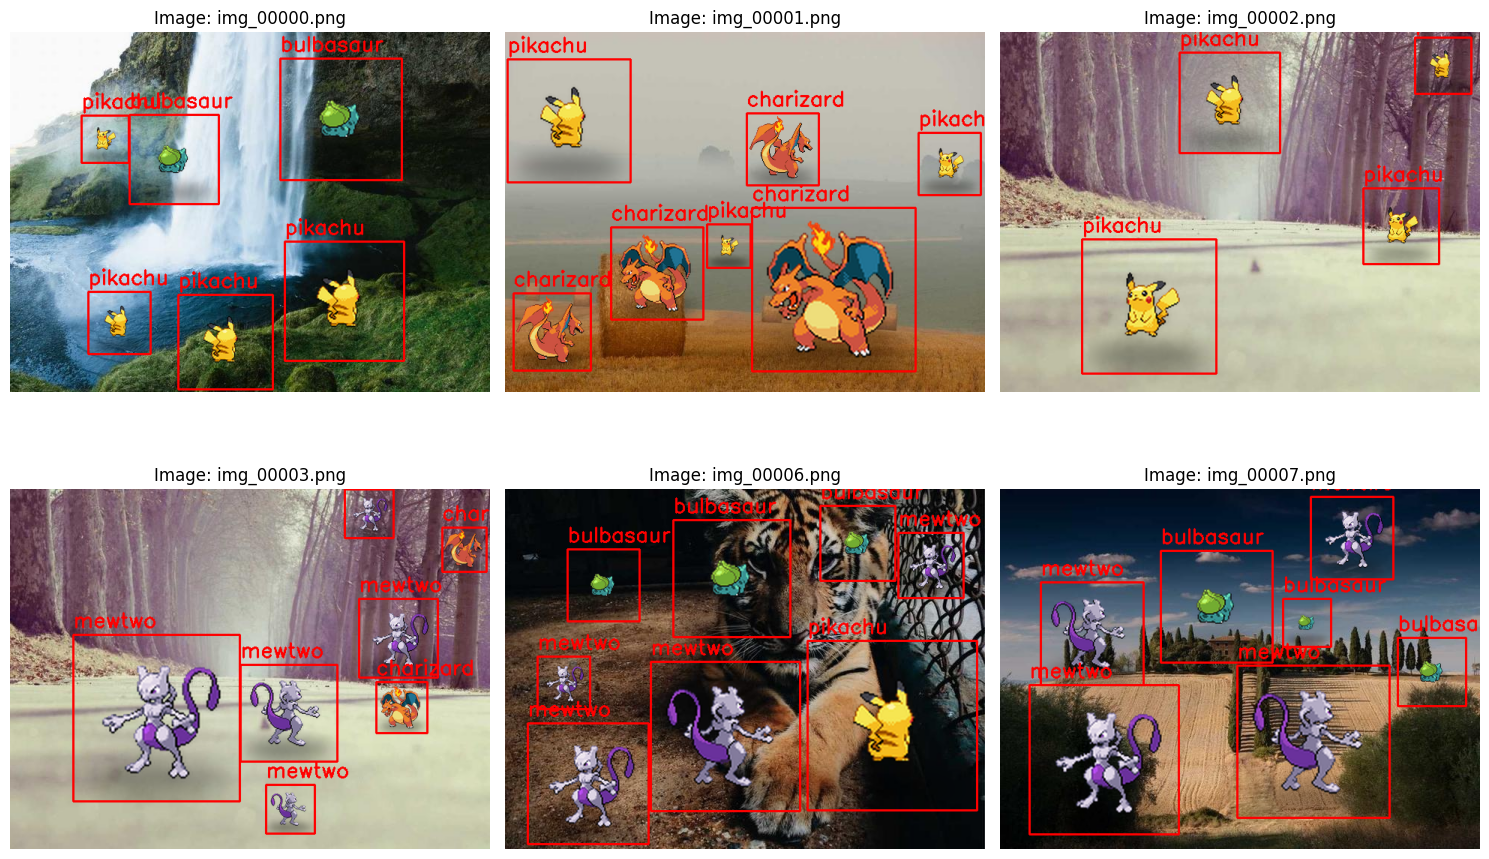

In [18]:
# Function to visualize sample images with annotations
def visualize_coco_sample(image_info, annotations, categories, images_path):
    # Load image
    img_path = os.path.join(images_path, image_info['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create category id to name mapping
    cat_id_to_name = {cat['id']: cat['name'] for cat in categories}

    # Draw bounding boxes
    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            bbox = ann['bbox']  # [x, y, width, height]
            x, y, w, h = bbox

            # Draw rectangle
            cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)

            # Add label
            label = cat_id_to_name[ann['category_id']]
            cv2.putText(img, label, (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img

# Show first 6 images with annotations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, len(coco_data['images']))):
    img_info = coco_data['images'][i]
    img_with_boxes = visualize_coco_sample(
        img_info, coco_data['annotations'], coco_data['categories'], 'content/dataset/images'
    )

    axes[i].imshow(img_with_boxes)
    axes[i].set_title(f"Image: {img_info['file_name']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Convert Data to yolo required format

In [19]:
def convert_coco_to_yolo(coco_data, output_dir):
    """Convert COCO format annotations to YOLO format"""
    # Create output directories
    os.makedirs(f"{output_dir}/images/train", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/train", exist_ok=True)

    # Create image id to image info mapping
    image_id_to_info = {img['id']: img for img in coco_data['images']}

    # Create category id to index mapping (YOLO uses 0-based indexing)
    category_mapping = {}
    for i, category in enumerate(coco_data['categories']):
        category_mapping[category['id']] = i

    # Group annotations by image_id
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)

    # Process each image
    for image_id, image_info in image_id_to_info.items():
        # Copy image file
        src_img_path = f"content/dataset/images/{image_info['file_name']}"
        dst_img_path = f"{output_dir}/images/train/{image_info['file_name']}"
        if os.path.exists(src_img_path):
            shutil.copy2(src_img_path, dst_img_path)

        # Create YOLO format label file
        label_filename = image_info['file_name'].replace('.png', '.txt').replace('.jpg', '.txt')
        label_path = f"{output_dir}/labels/train/{label_filename}"

        with open(label_path, 'w') as f:
            if image_id in annotations_by_image:
                for ann in annotations_by_image[image_id]:
                    # Convert COCO bbox to YOLO format
                    x, y, w, h = ann['bbox']
                    img_w, img_h = image_info['width'], image_info['height']

                    # Convert to YOLO format (normalized center coordinates)
                    x_center = (x + w / 2) / img_w
                    y_center = (y + h / 2) / img_h
                    width = w / img_w
                    height = h / img_h

                    # Get class index
                    class_id = category_mapping[ann['category_id']]

                    # Write YOLO format line
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return category_mapping

# Convert the dataset
yolo_dataset_dir = "content/pokemon_yolo_dataset"
category_mapping = convert_coco_to_yolo(coco_data, yolo_dataset_dir)

print("COCO to YOLO conversion completed!")
print(f"Category mapping: {category_mapping}")

# Verify conversion
print(f"\nImages in train folder: {len(os.listdir(f'{yolo_dataset_dir}/images/train'))}")
print(f"Labels in train folder: {len(os.listdir(f'{yolo_dataset_dir}/labels/train'))}")


COCO to YOLO conversion completed!
Category mapping: {1: 0, 2: 1, 3: 2, 4: 3}

Images in train folder: 52
Labels in train folder: 450


### Create Yolo Config

In [20]:
# Create YAML configuration file for YOLOv8
yaml_config = {
    'path': yolo_dataset_dir,
    'train': 'images/train',
    'val': 'images/train',  # Using same data for validation initially
    'nc': len(coco_data['categories']),  # number of classes
    'names': [cat['name'] for cat in sorted(coco_data['categories'], key=lambda x: category_mapping[x['id']])]
}

yaml_path = f"{yolo_dataset_dir}/pokemon_dataset.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print("YAML configuration created:")
with open(yaml_path, 'r') as f:
    print(f.read())


YAML configuration created:
names:
- pikachu
- charizard
- bulbasaur
- mewtwo
nc: 4
path: content/pokemon_yolo_dataset
train: images/train
val: images/train



In [21]:
import random

# Create validation split (20% of data)
def create_train_val_split(dataset_dir, val_ratio=0.2):
    train_images_dir = f"{dataset_dir}/images/train"
    train_labels_dir = f"{dataset_dir}/labels/train"

    val_images_dir = f"{dataset_dir}/images/val"
    val_labels_dir = f"{dataset_dir}/labels/val"

    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    # Get all image files
    image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Randomly select validation files
    random.seed(42)  # For reproducibility
    val_files = random.sample(image_files, int(len(image_files) * val_ratio))

    # Move validation files
    for img_file in val_files:
        # Move image
        src_img = os.path.join(train_images_dir, img_file)
        dst_img = os.path.join(val_images_dir, img_file)
        shutil.move(src_img, dst_img)

        # Move corresponding label
        label_file = img_file.replace('.png', '.txt').replace('.jpg', '.txt')
        src_label = os.path.join(train_labels_dir, label_file)
        dst_label = os.path.join(val_labels_dir, label_file)
        if os.path.exists(src_label):
            shutil.move(src_label, dst_label)

    print(f"Created validation split:")
    print(f"Training images: {len(os.listdir(train_images_dir))}")
    print(f"Validation images: {len(os.listdir(val_images_dir))}")

# Create the split
create_train_val_split(yolo_dataset_dir)

# Update YAML config
yaml_config['val'] = 'images/val'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)


Created validation split:
Training images: 42
Validation images: 10


### Set Training Paramters

In [22]:
# Load a pretrained YOLOv8 model
model = YOLO('yolov8s.pt')  # Using small model for faster training

print("Pretrained YOLOv8s model loaded successfully!")
print(f"Model summary:")
model.info()

# Train the model
results = model.train(
    data=yaml_path,           # path to dataset YAML
    epochs=100,               # number of training epochs
    imgsz=640,               # input image size
    batch=16,                # batch size (adjust based on your GPU memory)
    name='pokemon_detection', # experiment name
    cache=True,              # cache images for faster training
    device=0,                # GPU device (use 'cpu' if no GPU)
    workers=2,               # number of worker threads
    patience=20,             # early stopping patience
    save=True,               # save checkpoints
    plots=True,              # generate training plots
    val=True,                # validate during training
    lr0=0.01,               # initial learning rate
    weight_decay=0.0005,     # weight decay
    warmup_epochs=3,         # warmup epochs
    box=7.5,                # box loss gain
    cls=0.5,                # cls loss gain
    dfl=1.5,                # dfl loss gain
)

print("Training completed!")


Pretrained YOLOv8s model loaded successfully!
Model summary:
YOLOv8s summary: 129 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=content/pokemon_yolo_dataset/pokemon_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_

### View Training Results

Results directory: runs/detect/pokemon_detection

Results:


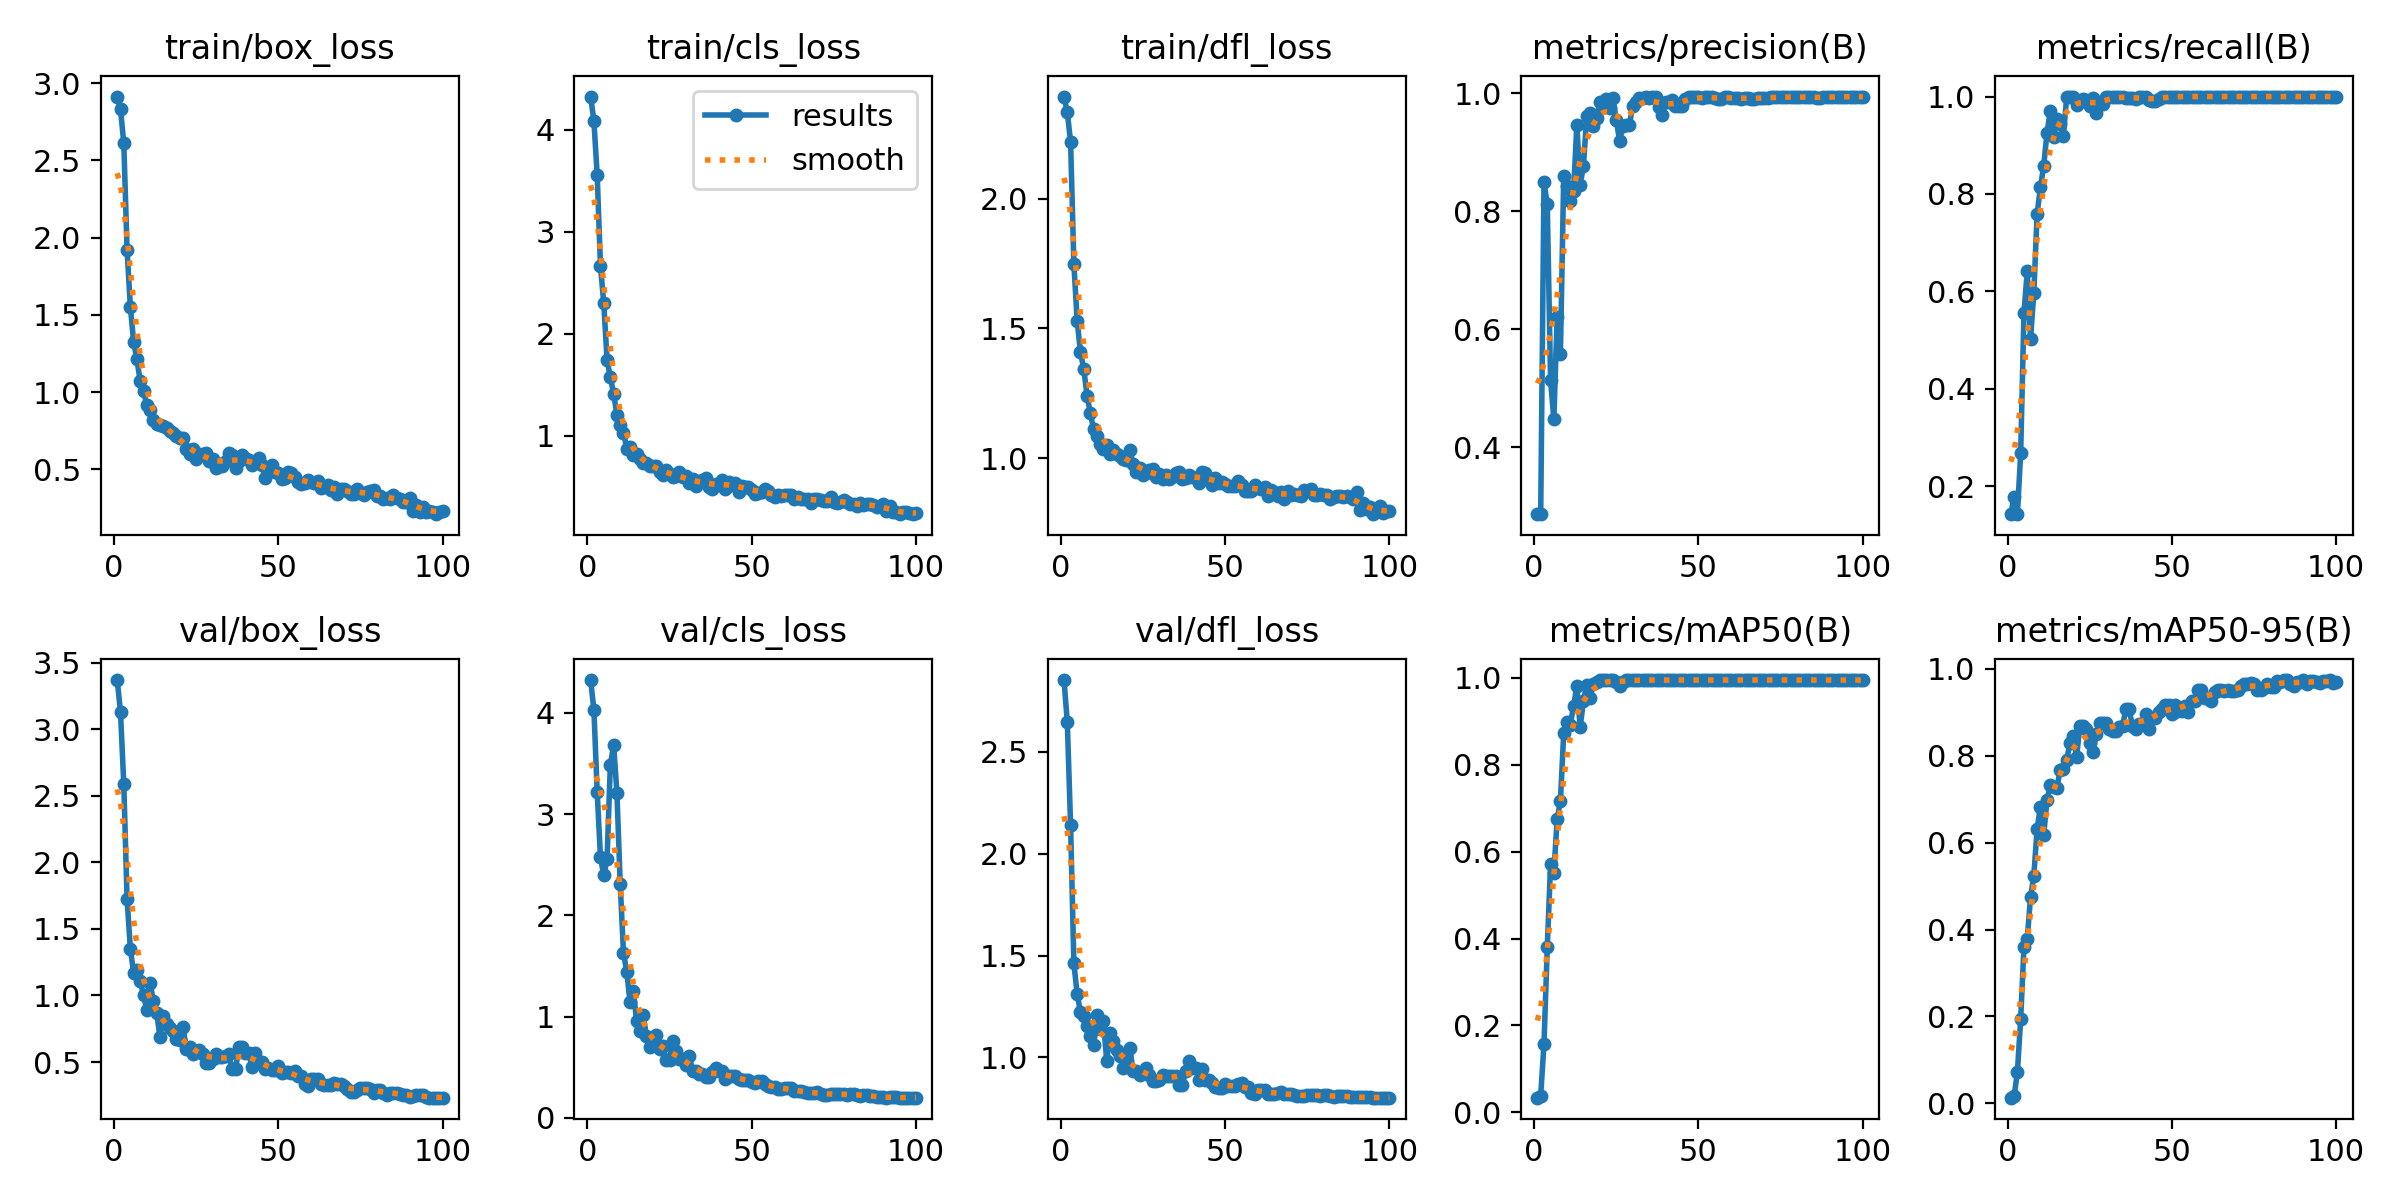


Confusion Matrix:


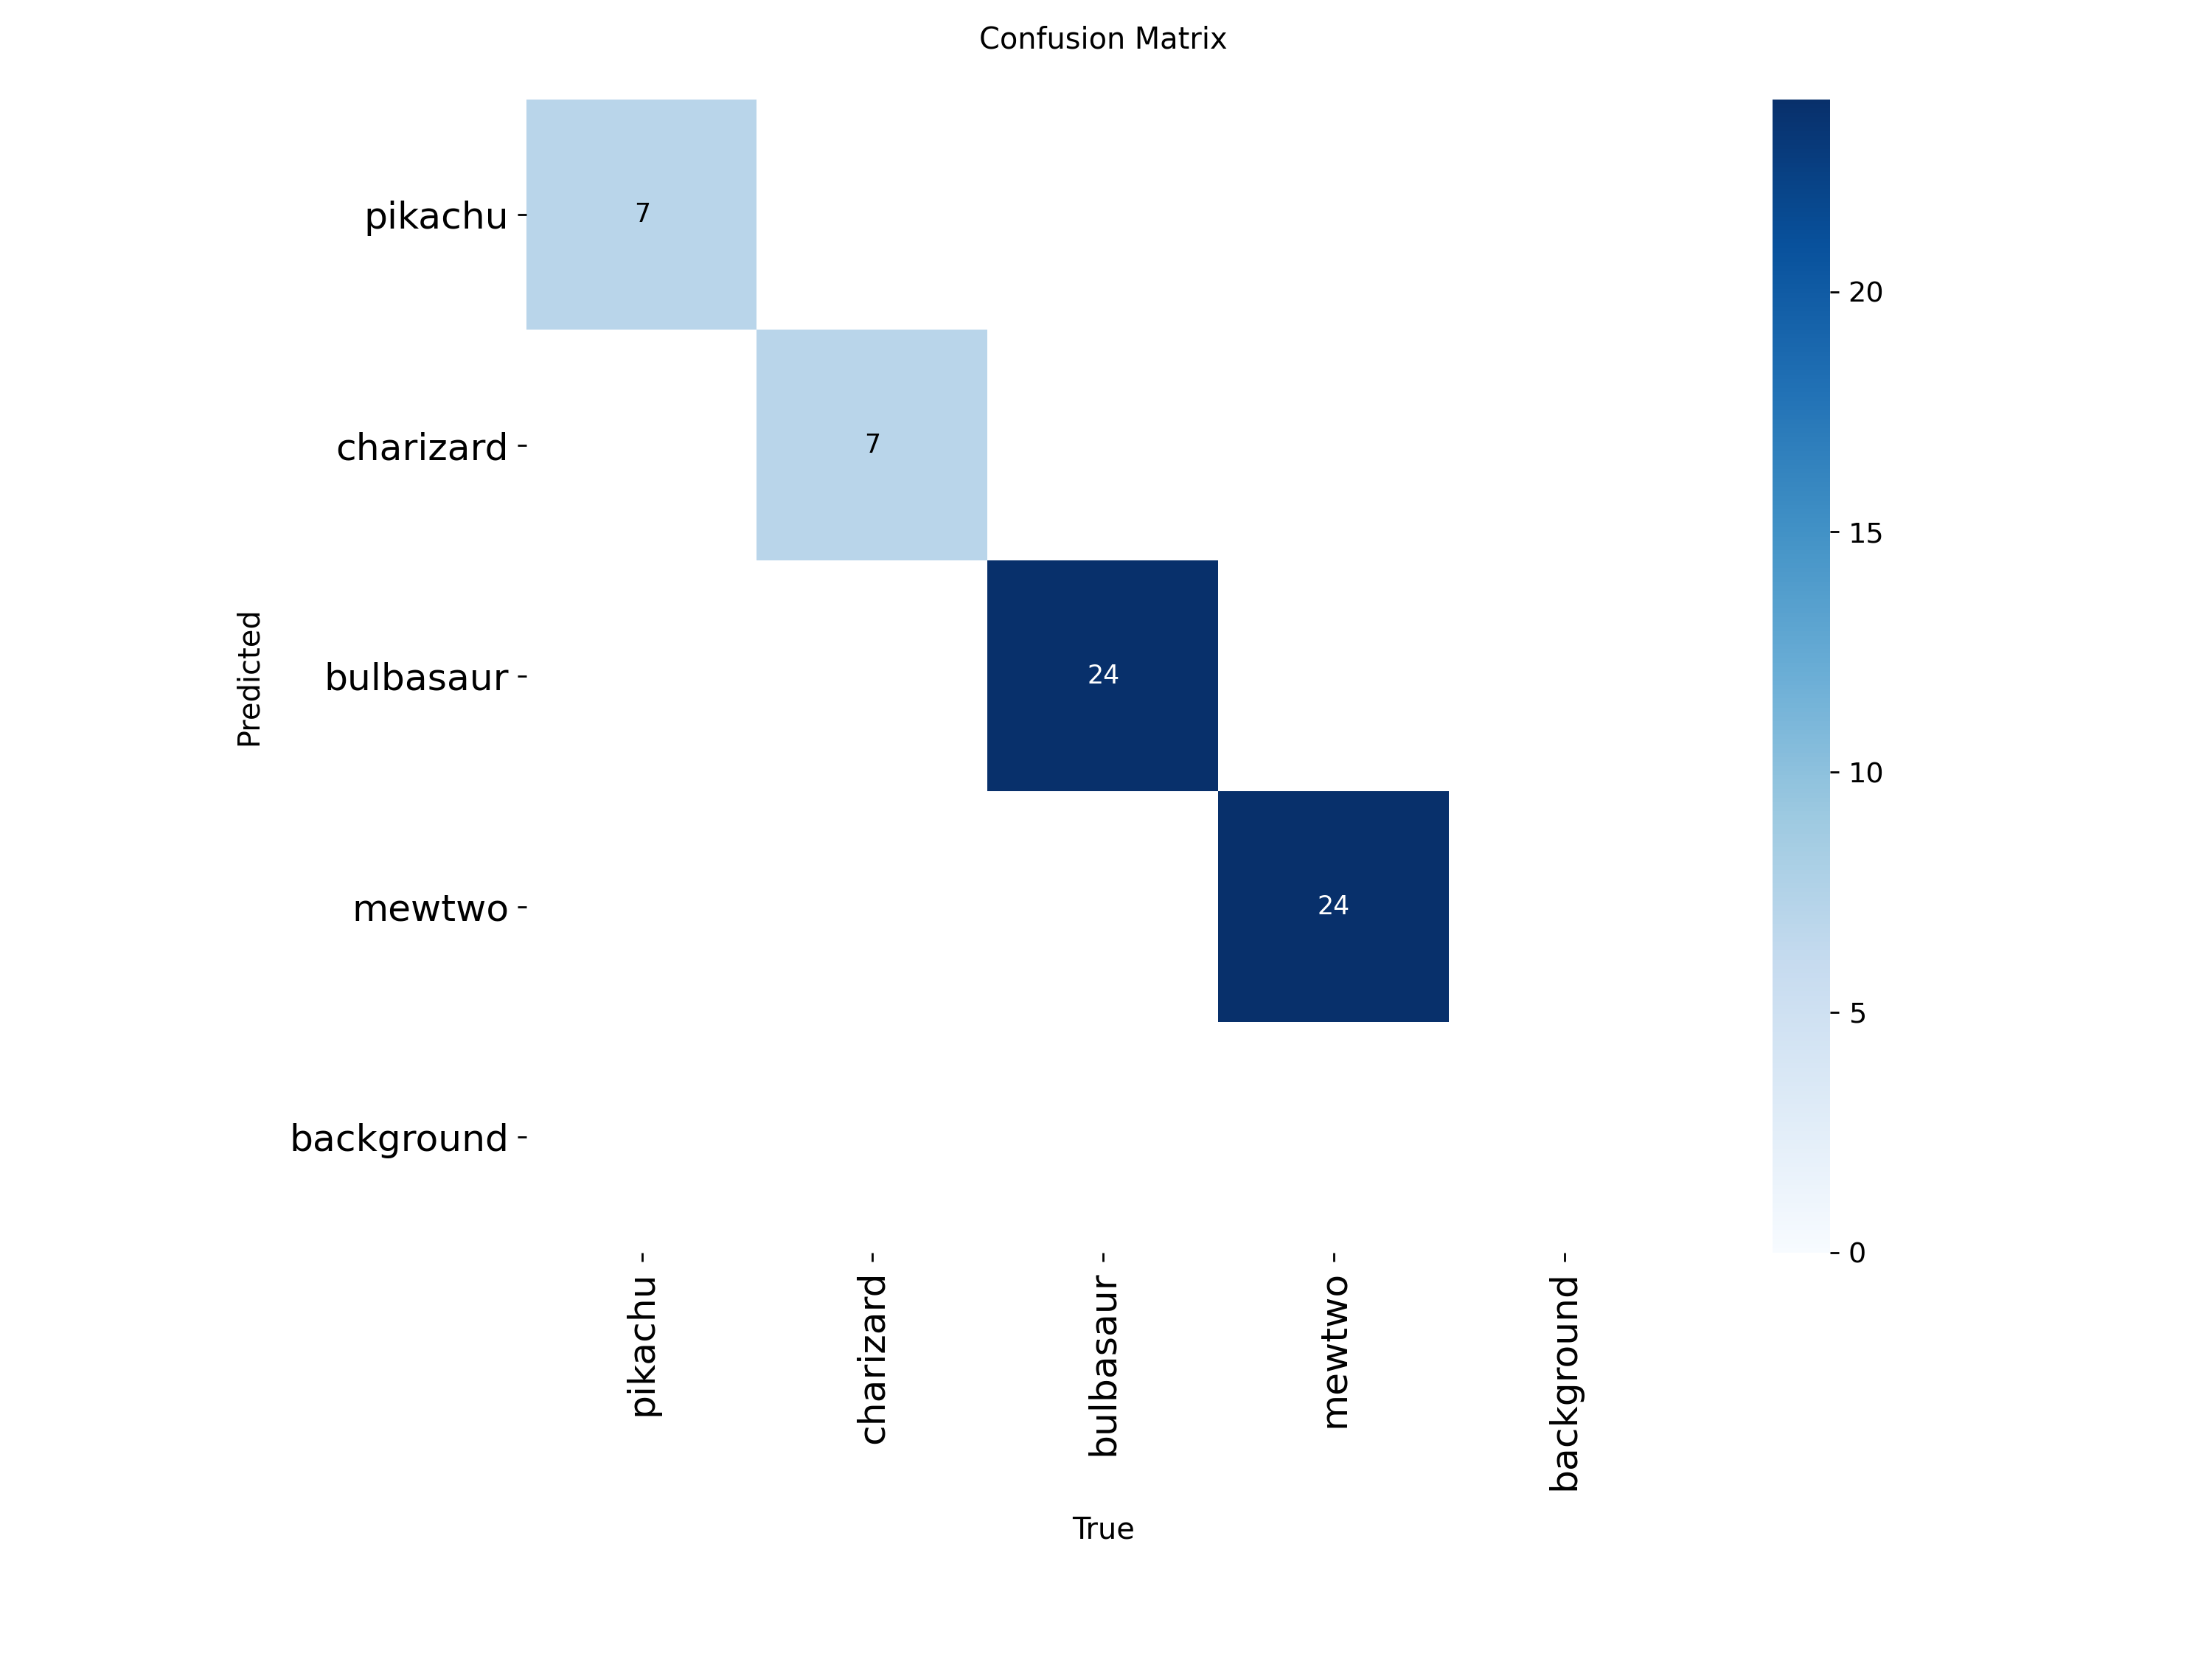


Boxf1 Curve:


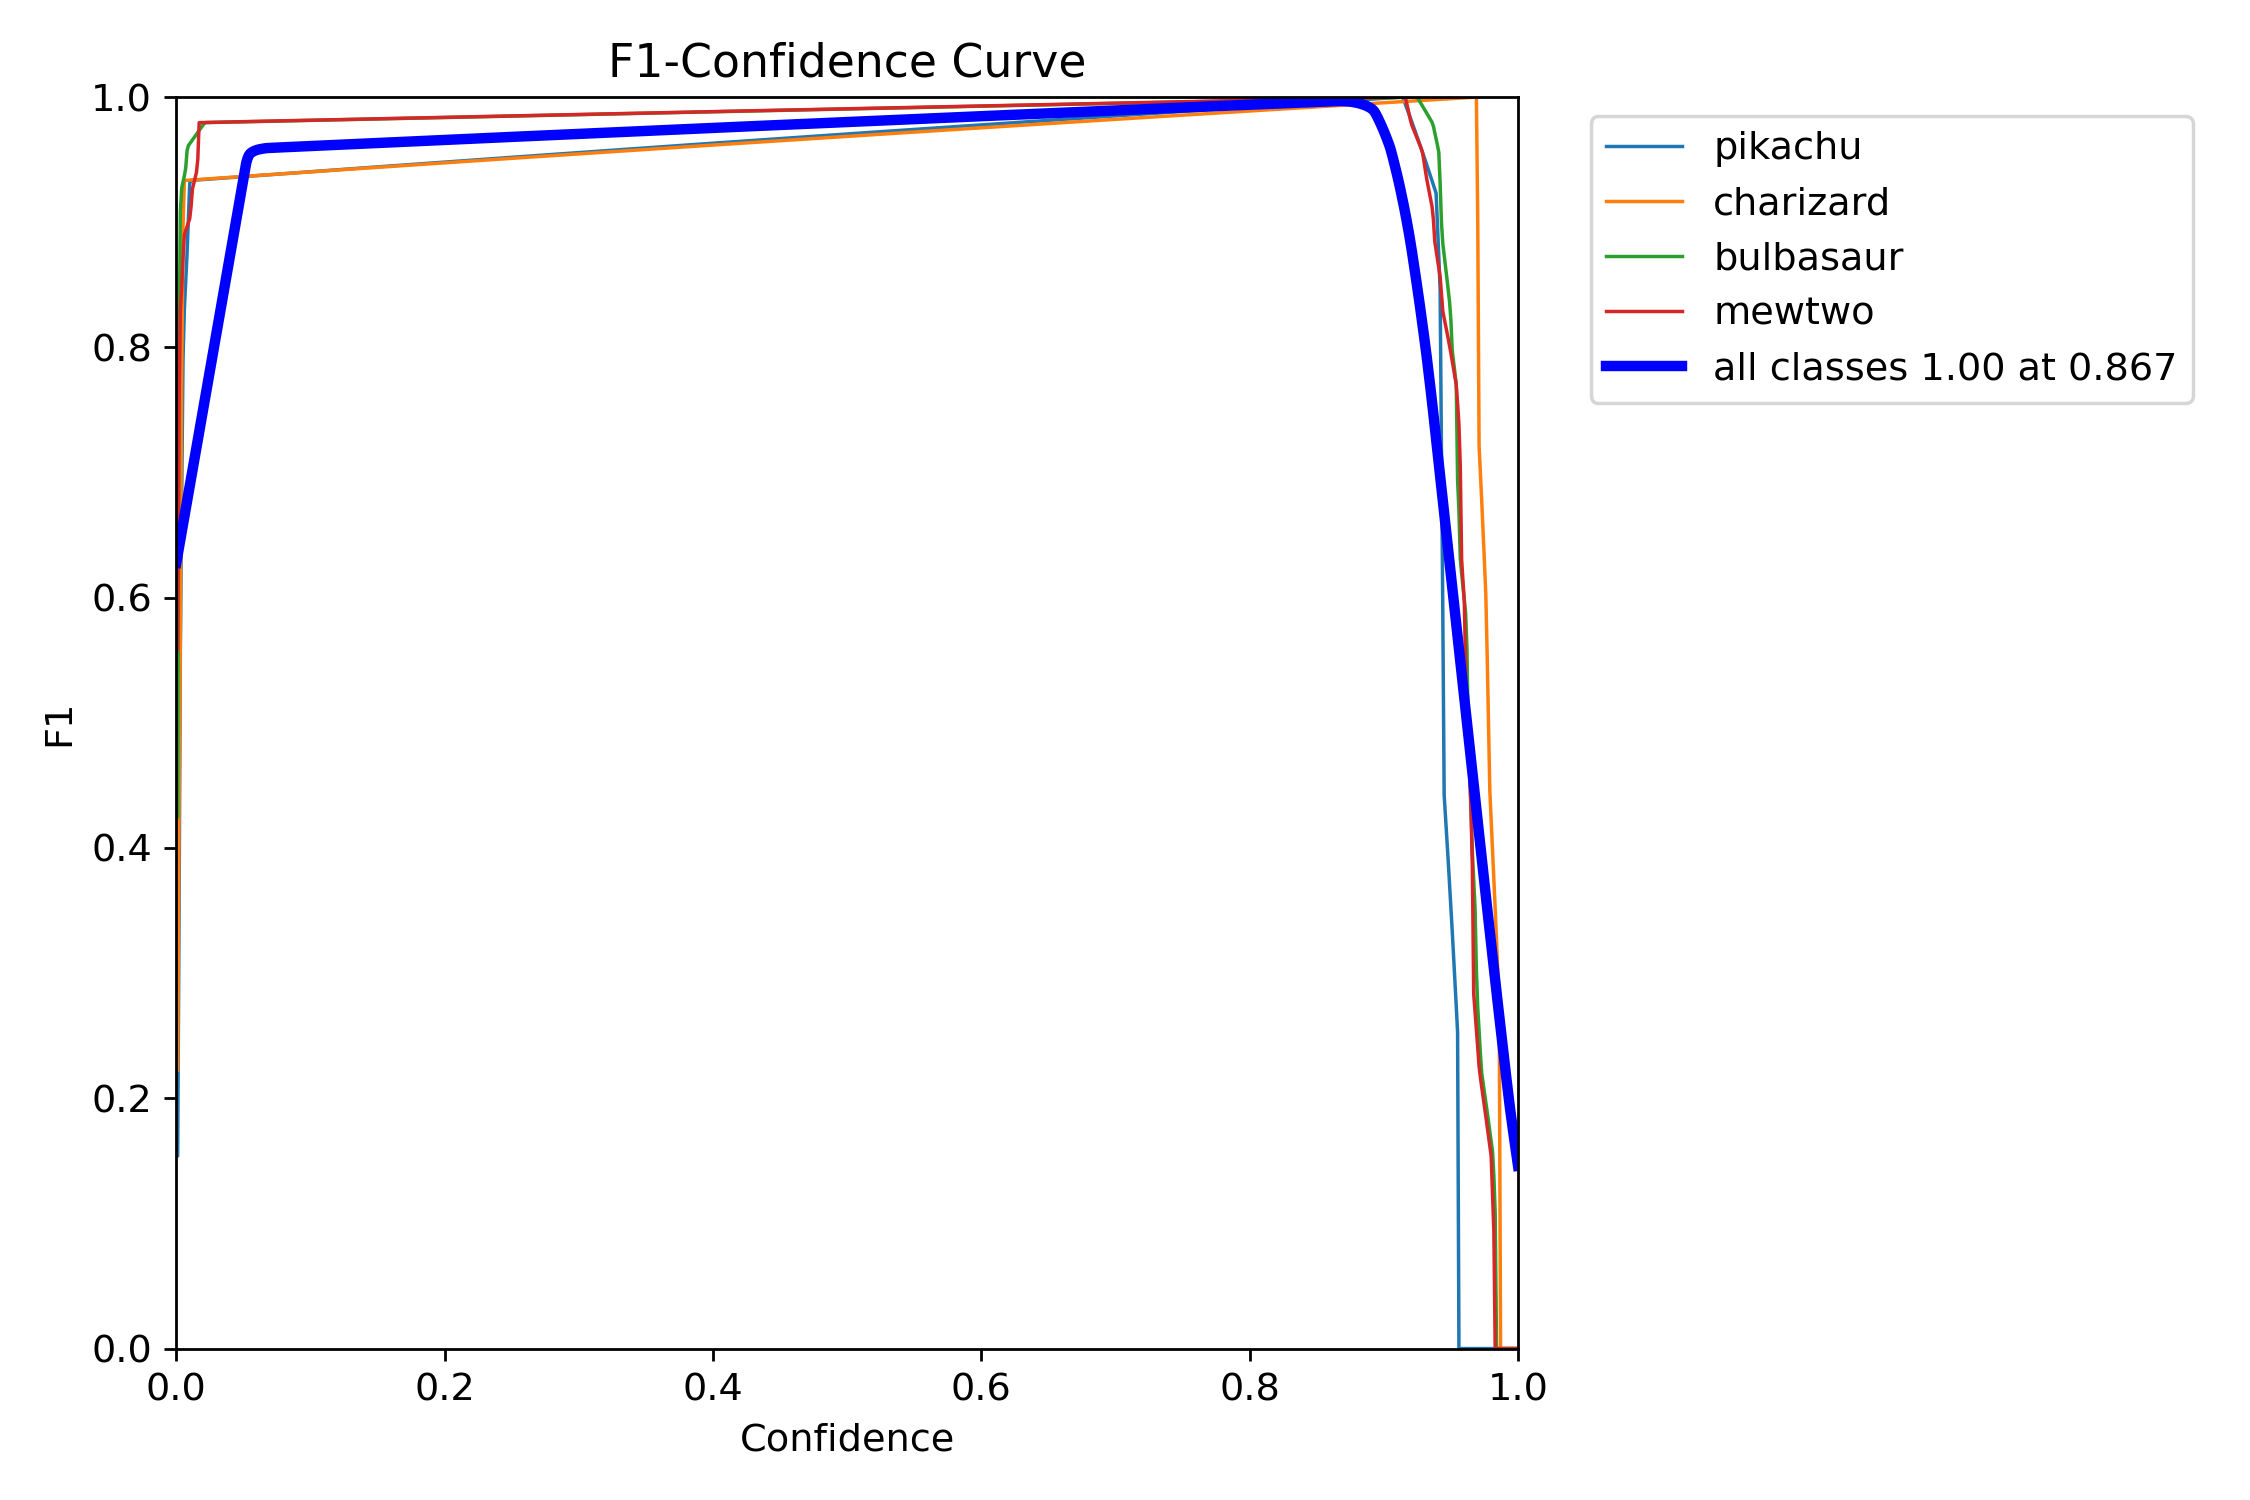


Boxpr Curve:


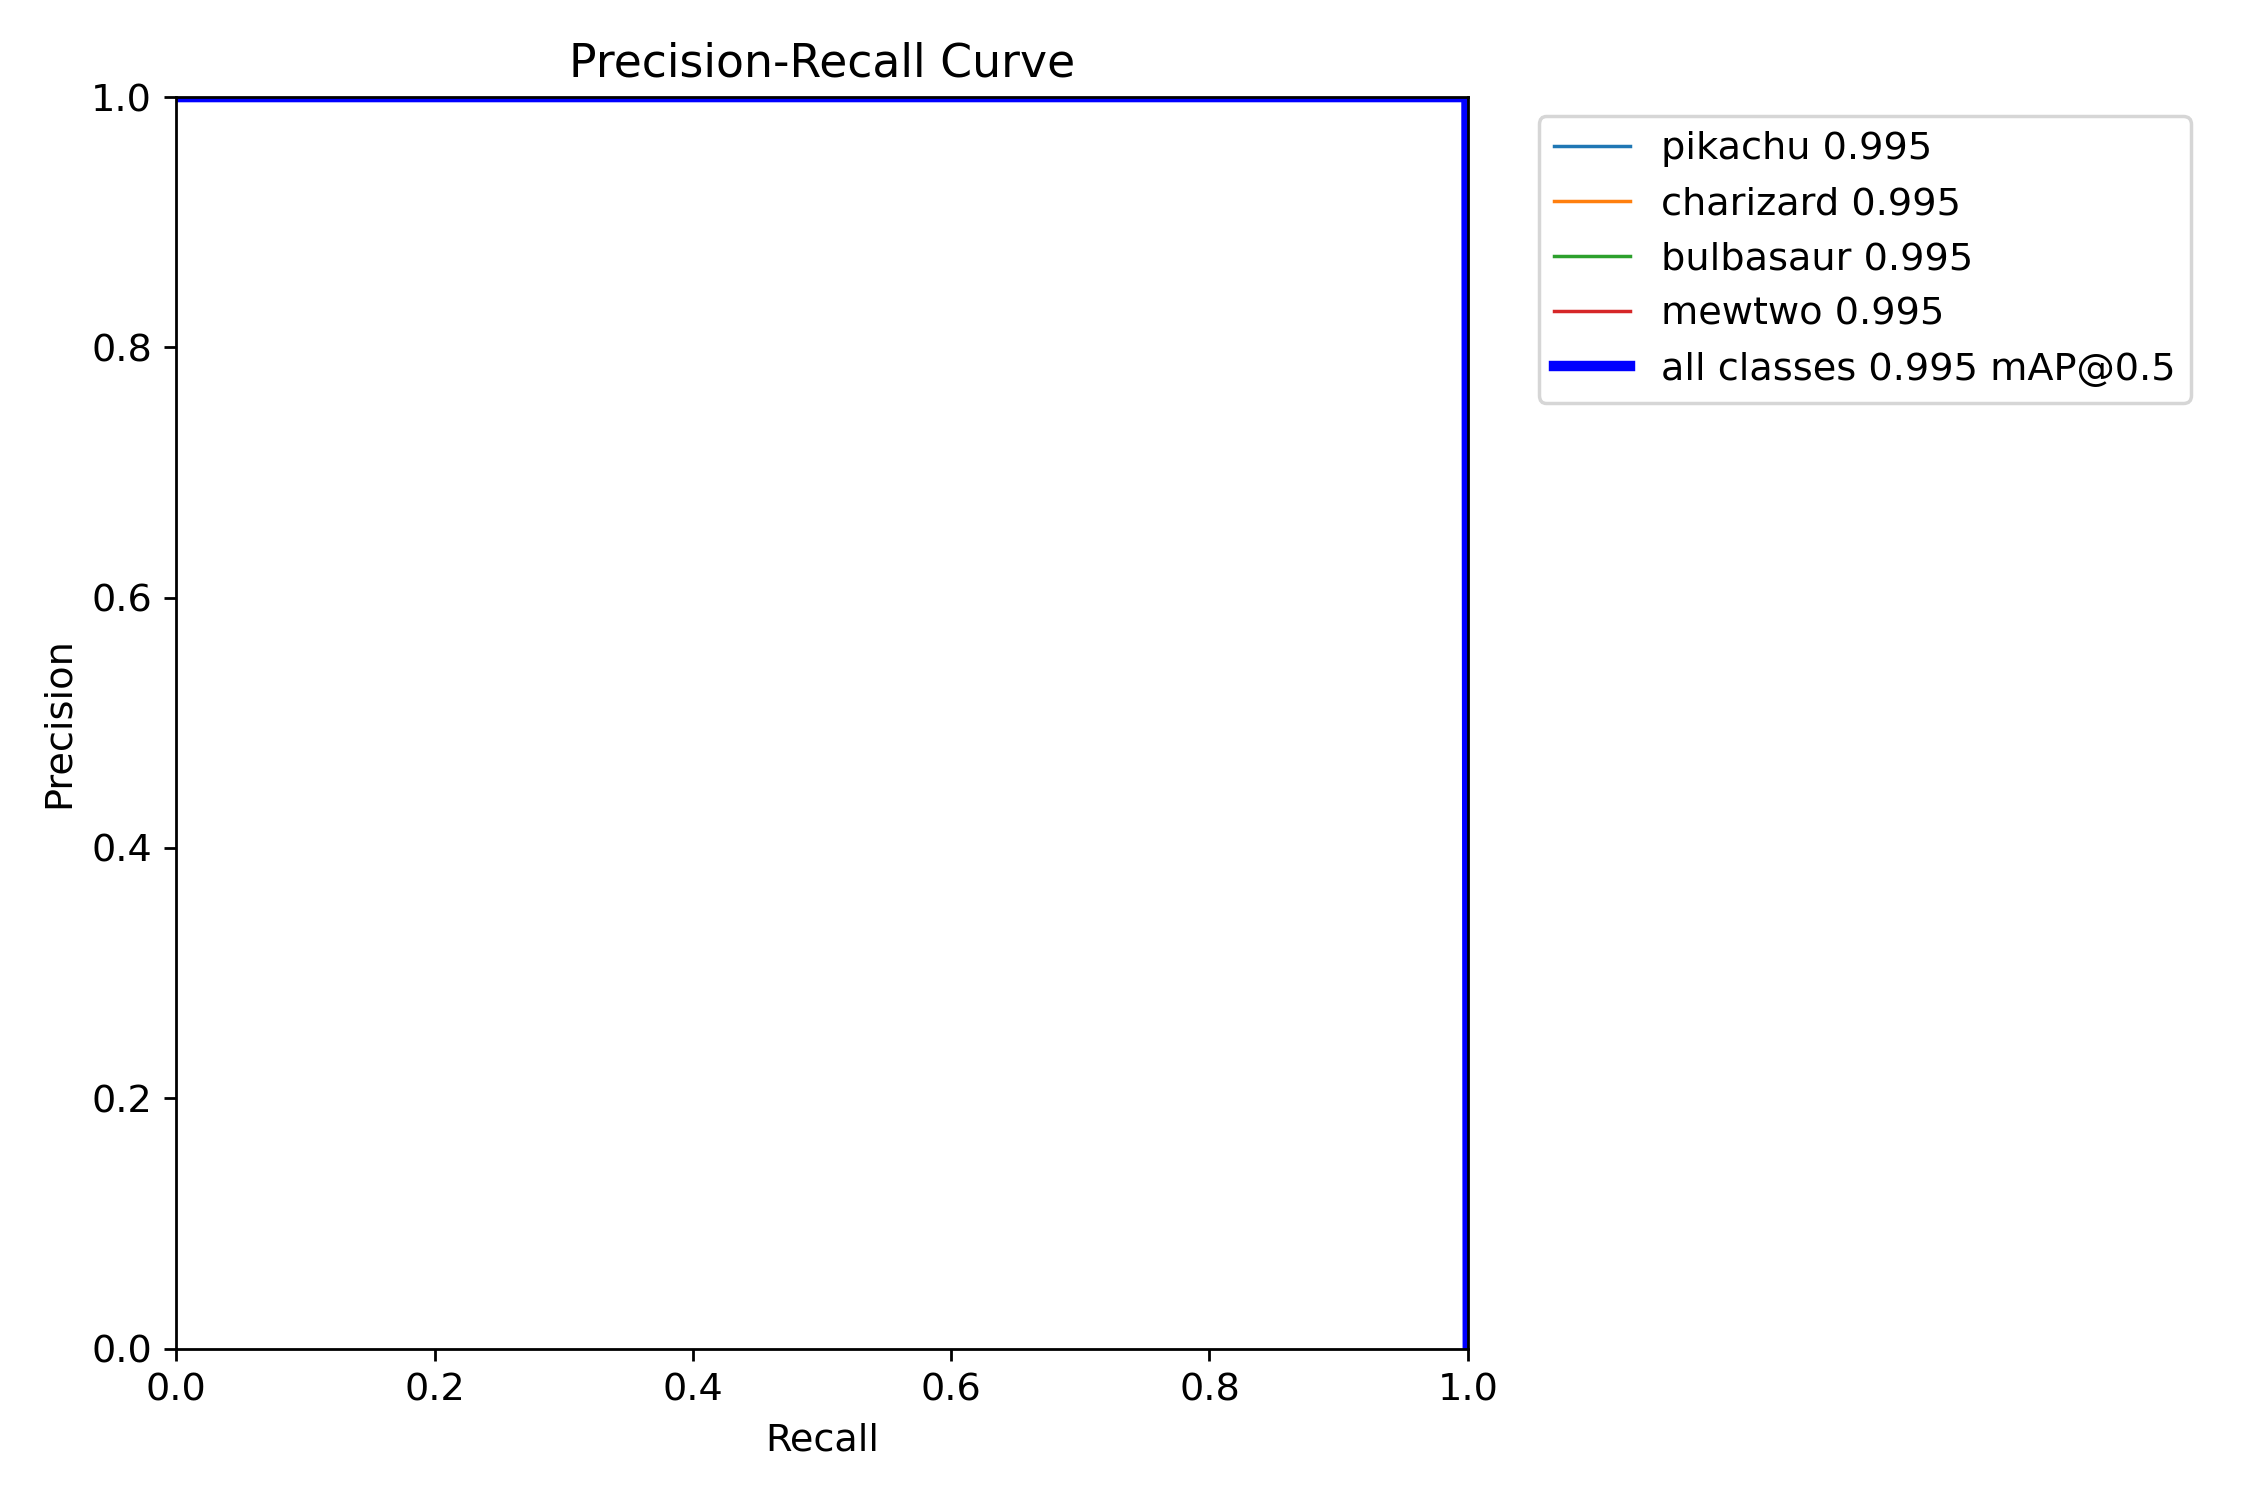


Boxp Curve:


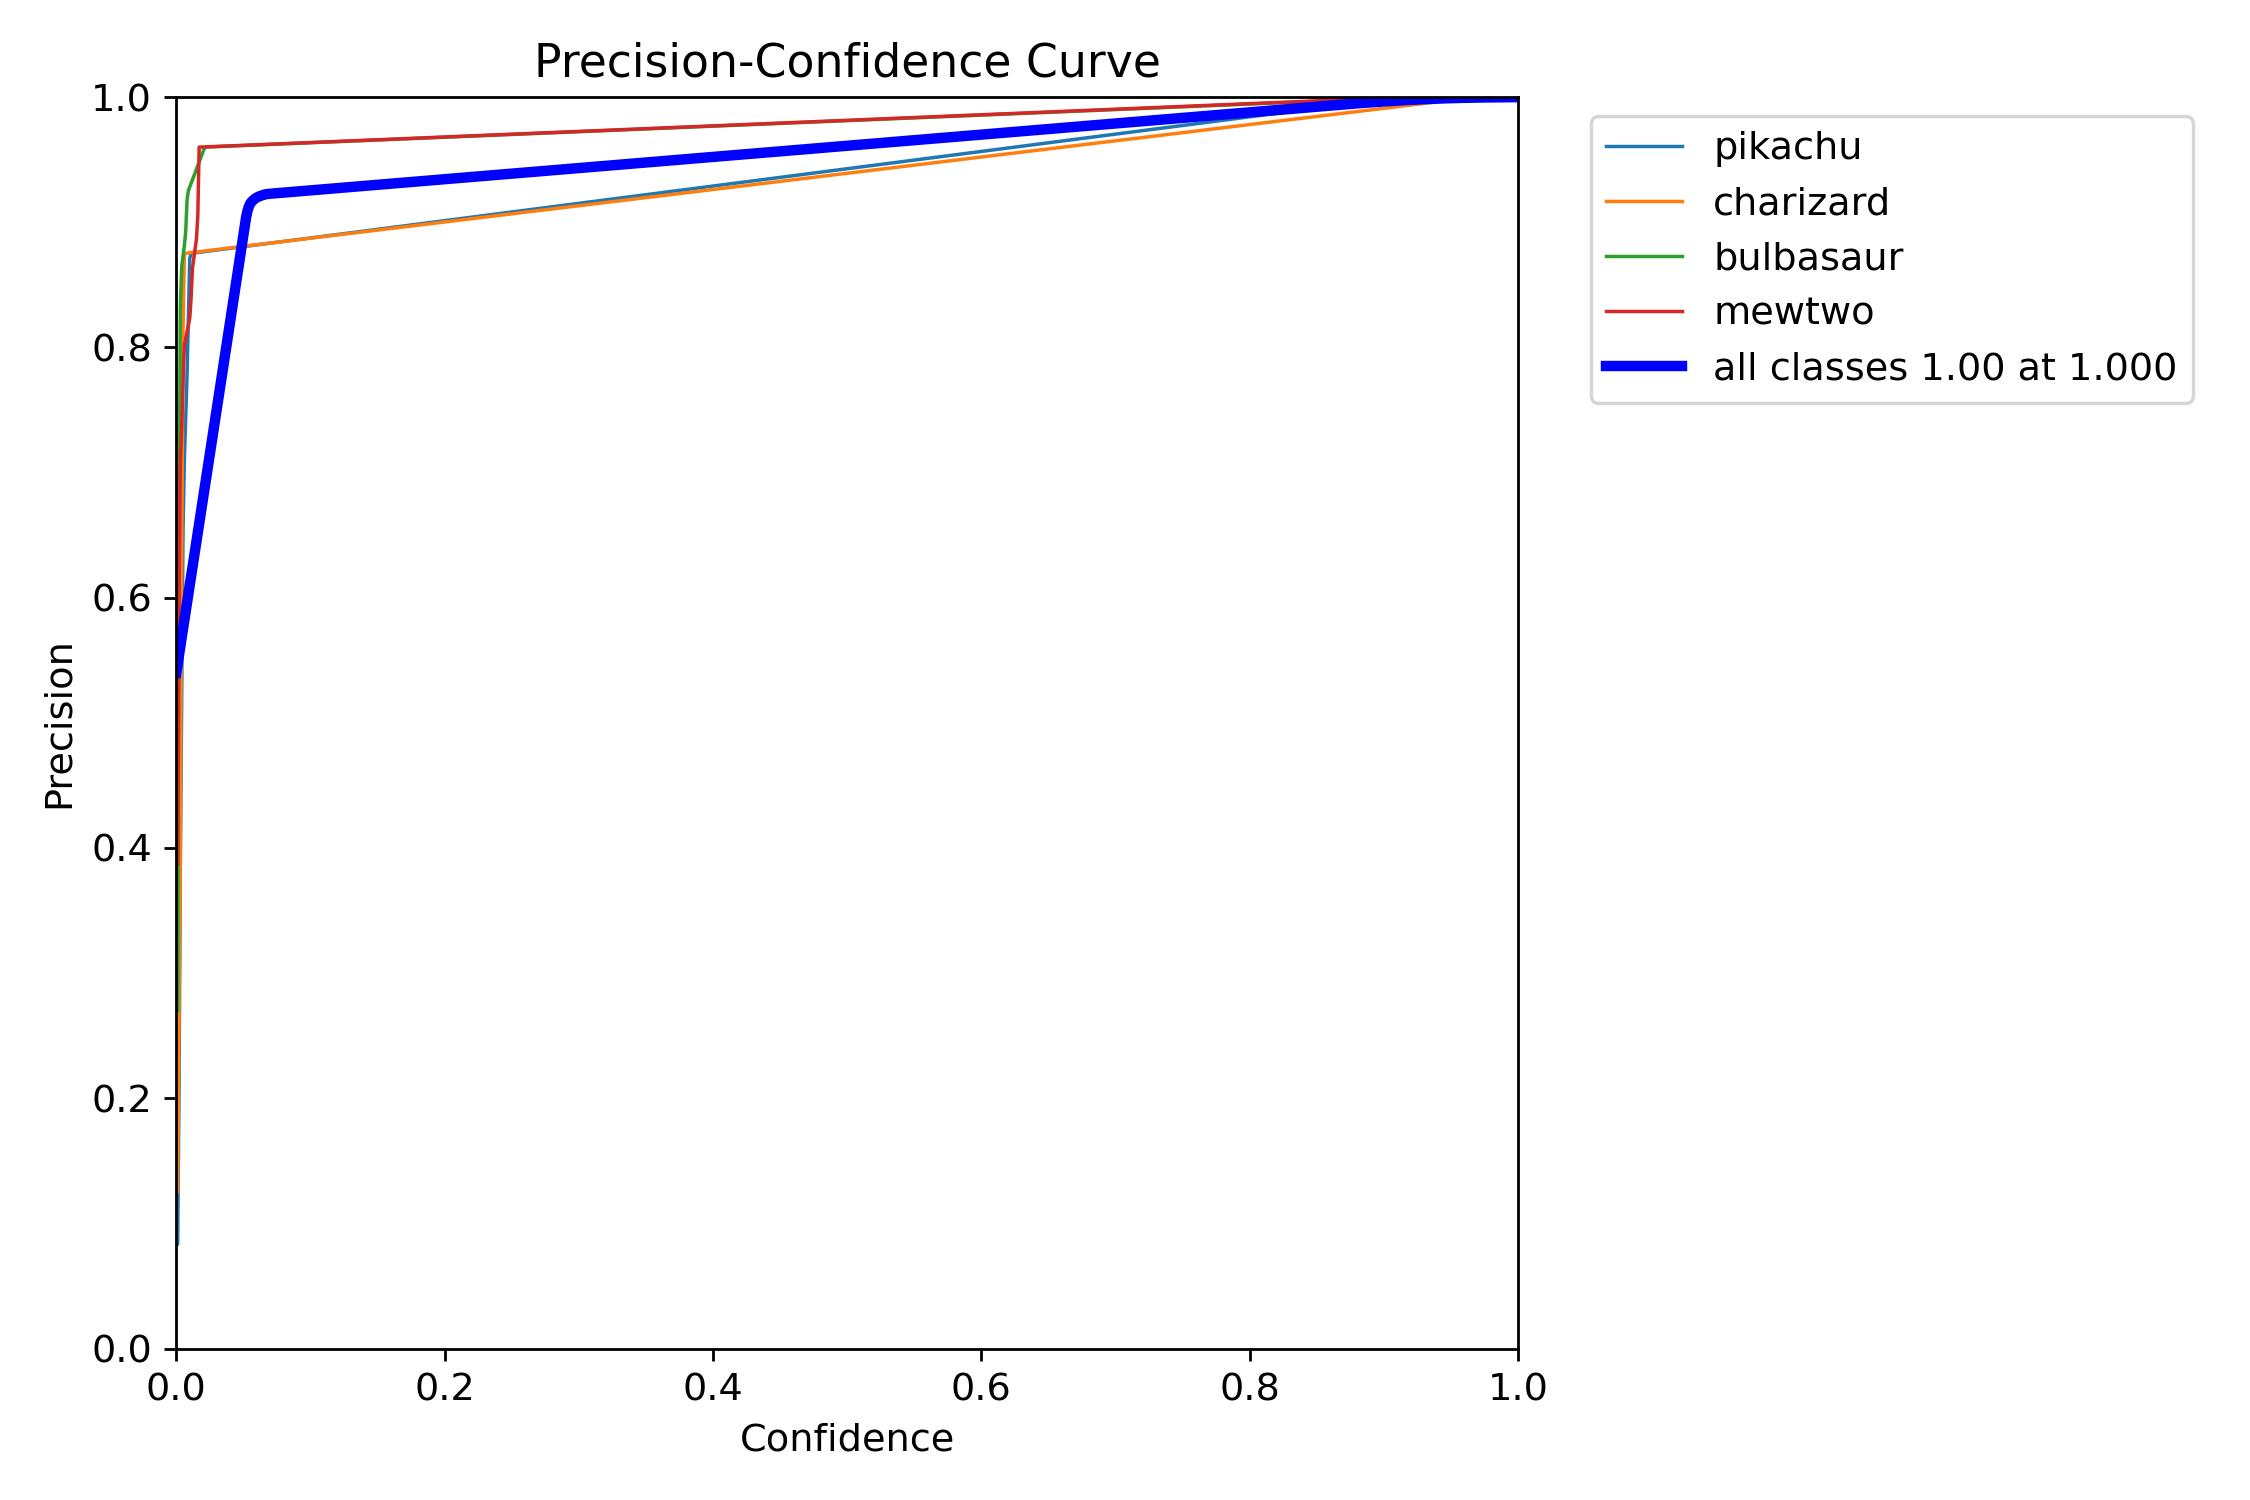


Boxr Curve:


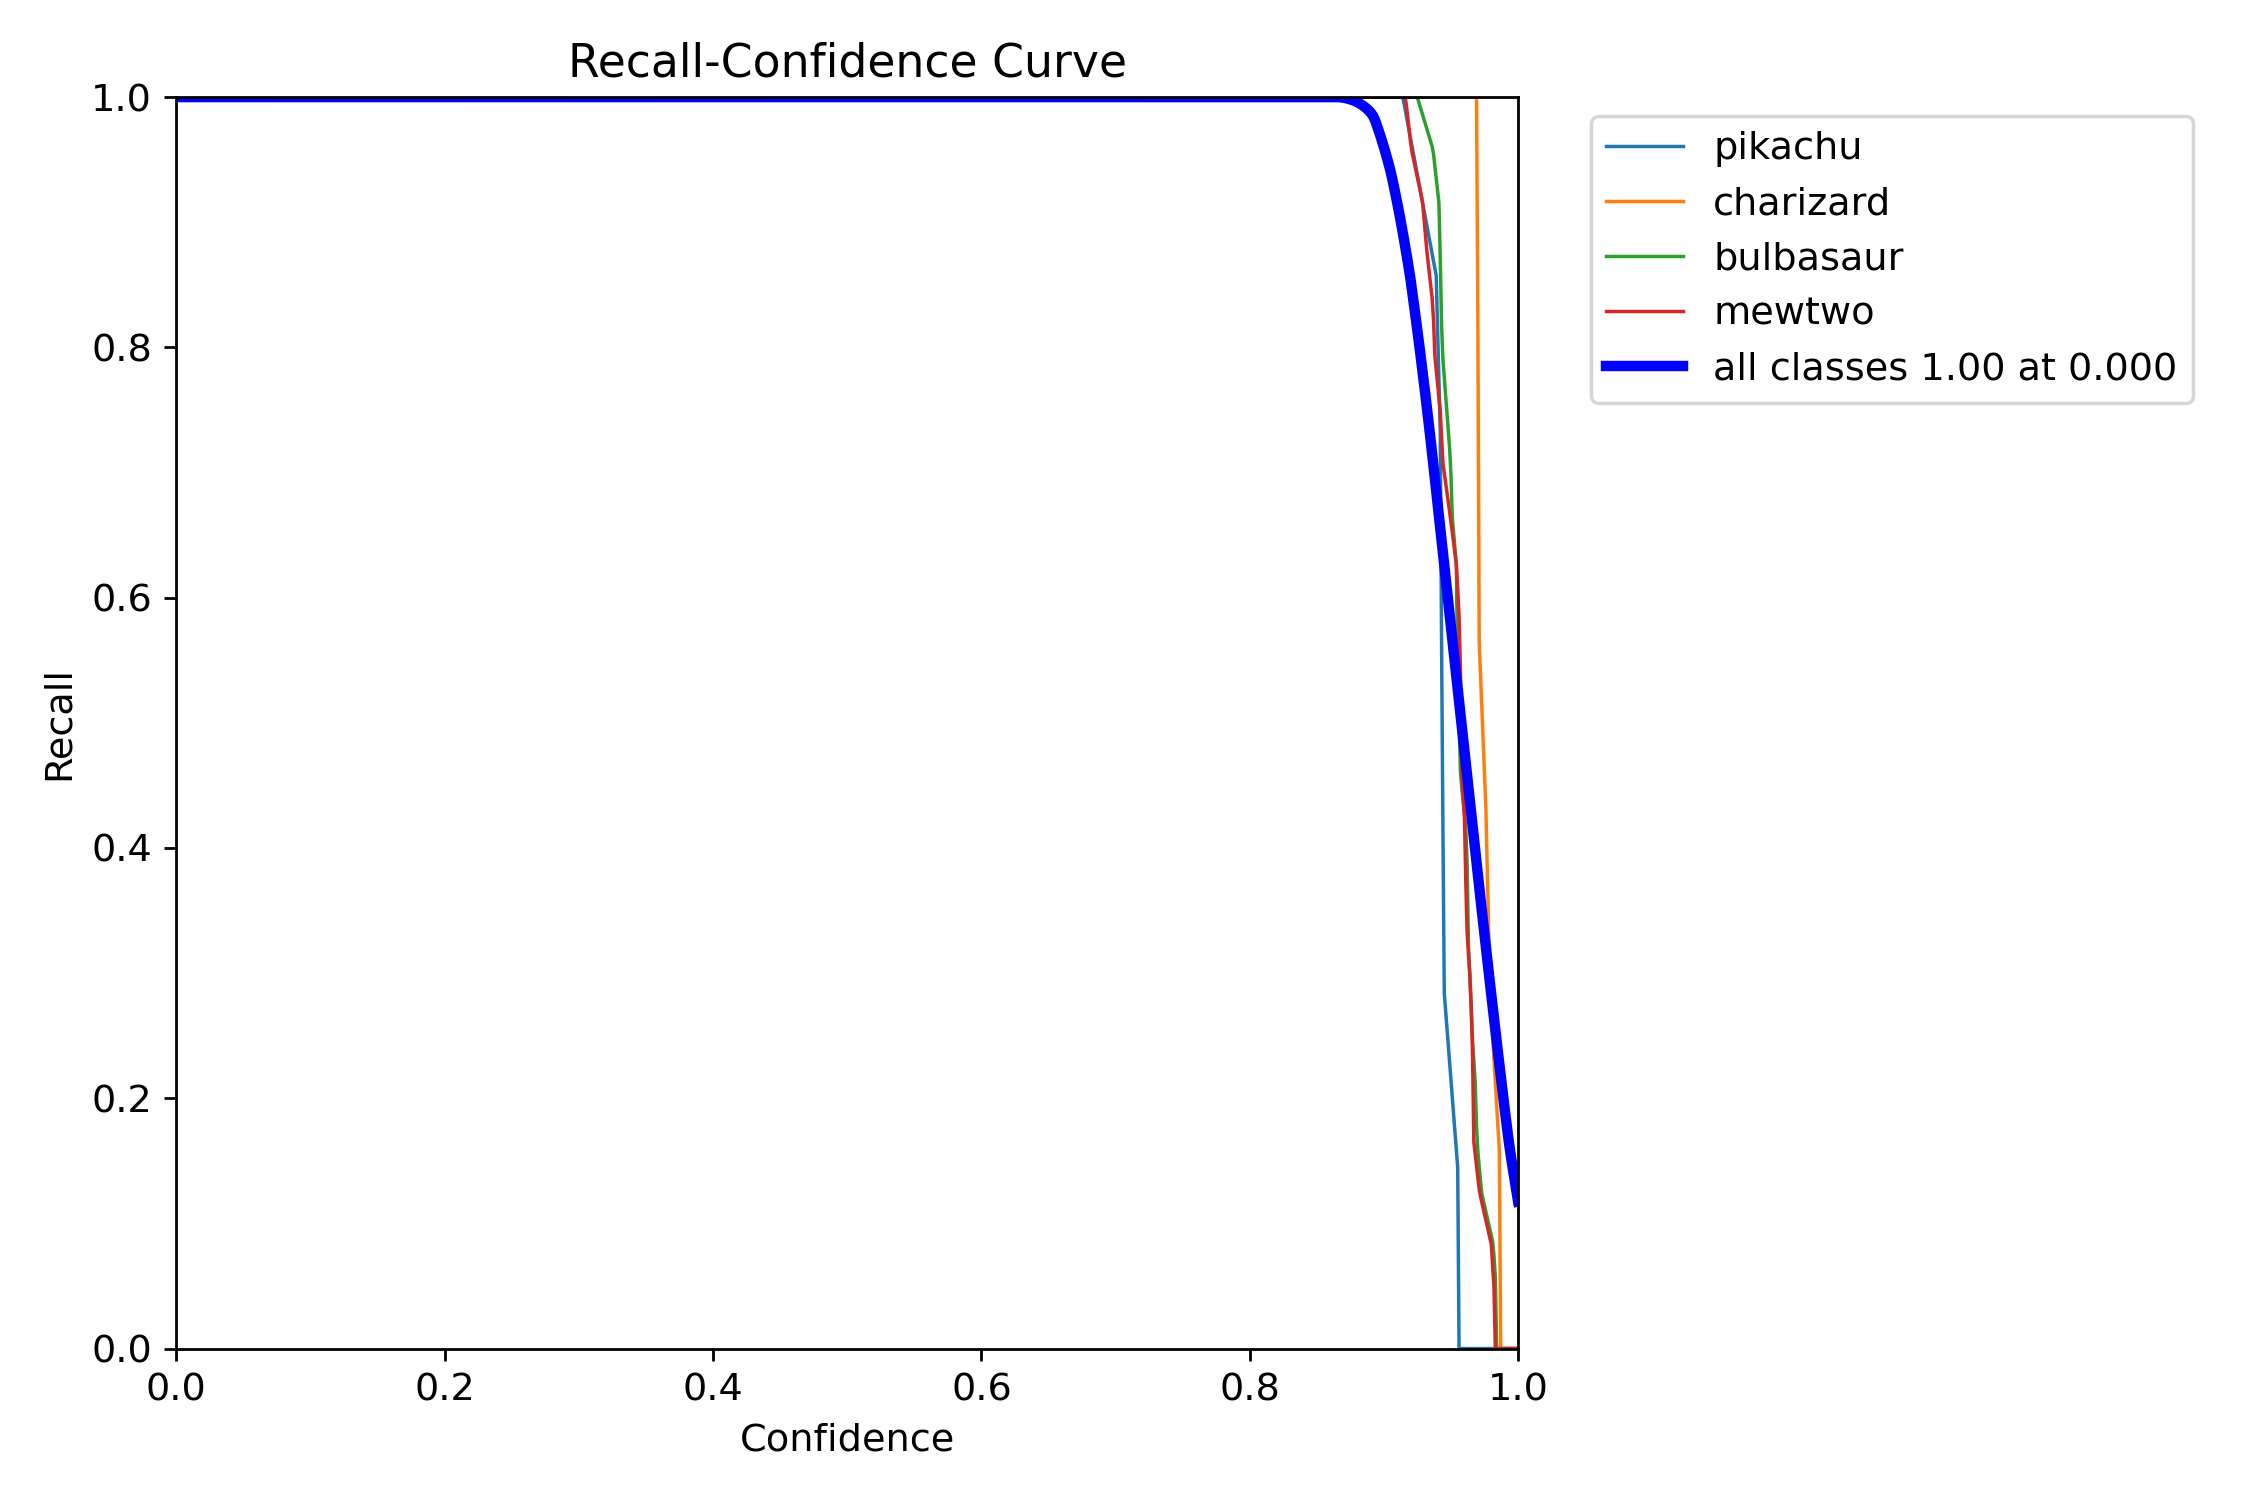

In [26]:
# Display training results
from IPython.display import Image, display
import glob

# Find the results directory
results_dir = glob.glob('runs/detect/pokemon_detection*')[-1]  # Get the latest run
print(f"Results directory: {results_dir}")

# Display training plots
plots = ['results.png', 'confusion_matrix.png', 'BoxF1_curve.png', 'BoxPR_curve.png', 'BoxP_curve.png', 'BoxR_curve.png']

for plot in plots:
    plot_path = f"{results_dir}/{plot}"
    if os.path.exists(plot_path):
        print(f"\n{plot.replace('_', ' ').replace('.png', '').title()}:")
        display(Image(plot_path))
    else:
        print(f"{plot} not found")


### Validate Model

In [27]:
# Load the best trained model
best_model_path = f"{results_dir}/weights/best.pt"
trained_model = YOLO(best_model_path)

# Validate the model
validation_results = trained_model.val(data=yaml_path)

print("Validation Results:")
print(f"mAP50: {validation_results.box.map50:.4f}")
print(f"mAP50-95: {validation_results.box.map:.4f}")

# Print per-class metrics
class_names = yaml_config['names']
print("\nPer-class mAP50:")
for i, class_name in enumerate(class_names):
    if i < len(validation_results.box.maps):
        print(f"{class_name}: {validation_results.box.maps[i]:.4f}")


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1950.2±431.3 MB/s, size: 370.2 KB)
val: Scanning /content/content/pokemon_yolo_dataset/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 4.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.8it/s 0.6s
                   all         10         62      0.994          1      0.995      0.971
               pikachu          6          7      0.993          1      0.995      0.941
             charizard          6          7      0.987          1      0.995      0.995
             bulbasaur         10         24      0.997          1      0.995      0.968
                mewtwo          9         24      0.998          1      0.995       0.98
Speed: 0.2ms preprocess, 21.4ms i

### Test on test dataset


image 1/1 /content/content/pokemon_yolo_dataset/images/val/img_00007.png: 480x640 3 bulbasaurs, 4 mewtwos, 46.8ms
Speed: 1.7ms preprocess, 46.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

Detections for img_00007.png:
  mewtwo: 0.967
  mewtwo: 0.963
  mewtwo: 0.962
  bulbasaur: 0.955
  bulbasaur: 0.949
  bulbasaur: 0.942
  mewtwo: 0.931

image 1/1 /content/content/pokemon_yolo_dataset/images/val/img_00006.png: 480x640 1 pikachu, 3 bulbasaurs, 4 mewtwos, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

Detections for img_00006.png:
  mewtwo: 0.979
  mewtwo: 0.961
  bulbasaur: 0.959
  bulbasaur: 0.953
  mewtwo: 0.950
  pikachu: 0.941
  bulbasaur: 0.941
  mewtwo: 0.916

image 1/1 /content/content/pokemon_yolo_dataset/images/val/img_00052.png: 480x640 1 pikachu, 1 charizard, 2 bulbasaurs, 1 mewtwo, 12.9ms
Speed: 1.5ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

Detectio

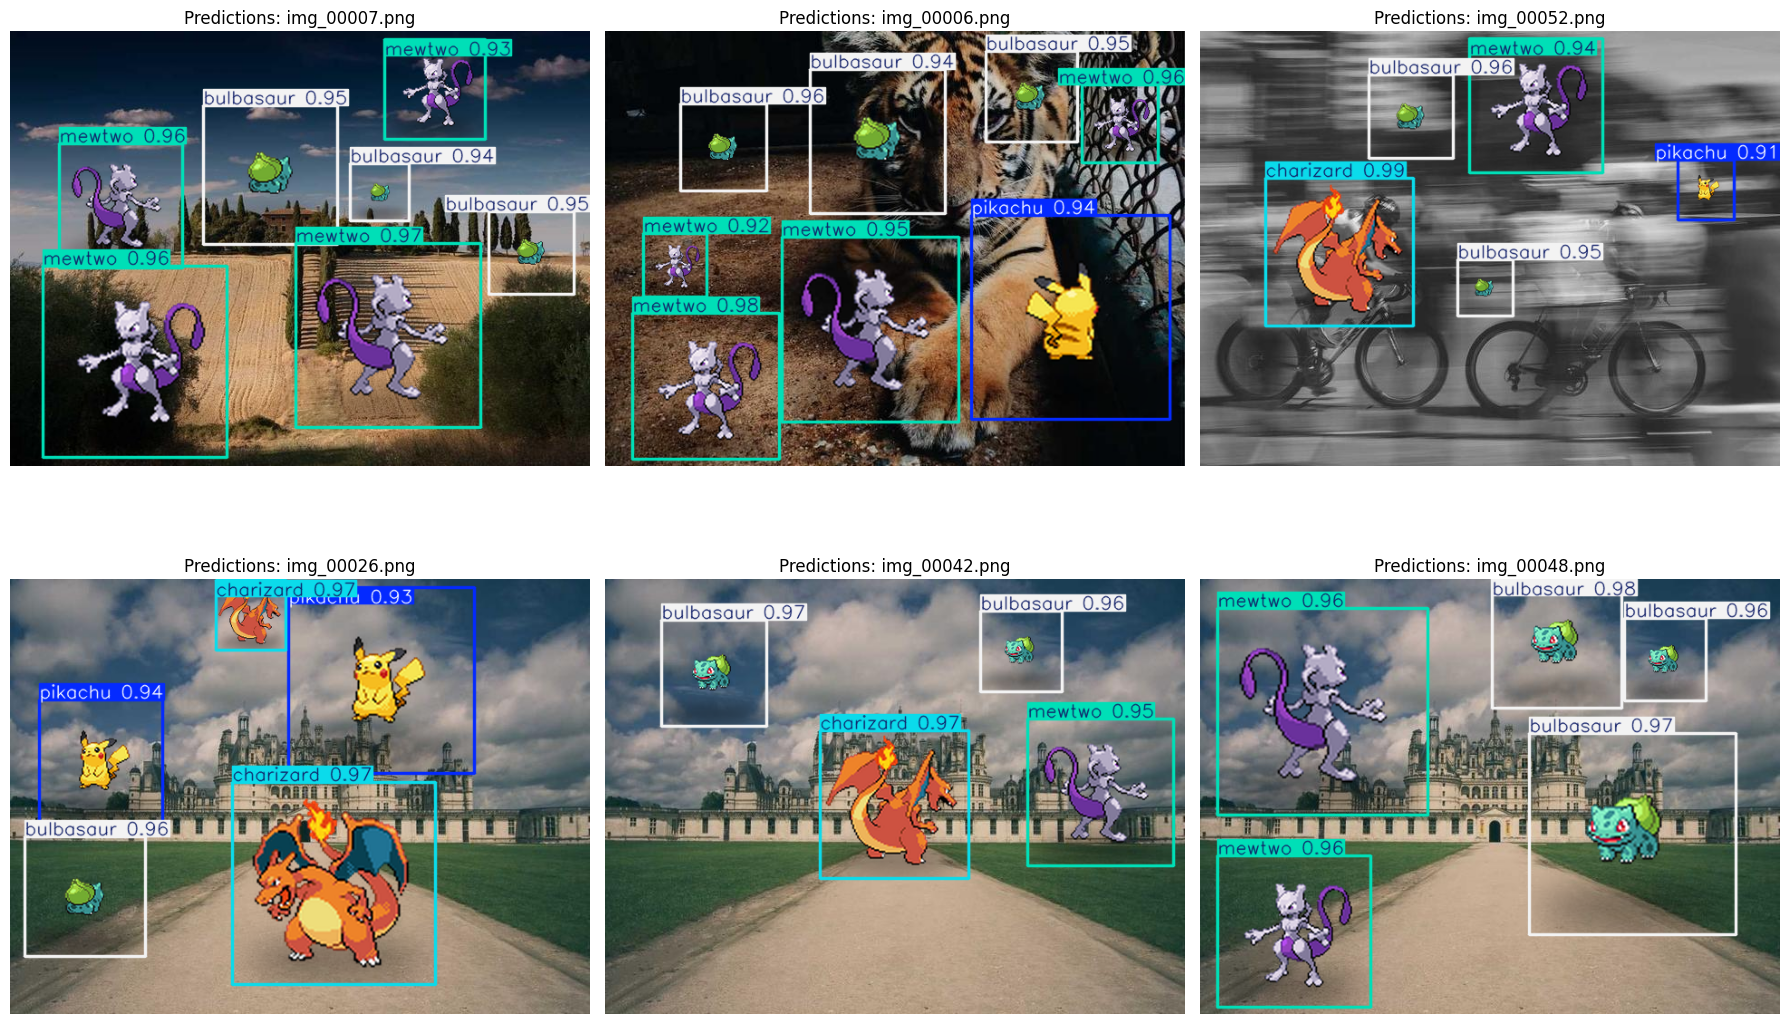

In [28]:
# Test inference on validation images
val_images_dir = f"{yolo_dataset_dir}/images/val"
test_images = os.listdir(val_images_dir)[:6]  # Test on first 6 validation images

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, img_name in enumerate(test_images):
    img_path = os.path.join(val_images_dir, img_name)

    # Run inference
    results = trained_model(img_path, conf=0.25)  # confidence threshold

    # Get the annotated image
    annotated_img = results[0].plot()

    # Convert BGR to RGB for matplotlib
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(annotated_img)
    axes[i].set_title(f"Predictions: {img_name}")
    axes[i].axis('off')

    # Print detection details
    print(f"\nDetections for {img_name}:")
    if len(results[0].boxes) > 0:
        for j, box in enumerate(results[0].boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = class_names[class_id]
            print(f"  {class_name}: {confidence:.3f}")
    else:
        print("  No detections")

plt.tight_layout()
plt.show()

### Test on custom image

Upload an image to test the trained model:


Saving img_00494.png to img_00494.png

Testing on img_00494.png:

image 1/1 /content/img_00494.png: 480x640 2 charizards, 5 bulbasaurs, 1 mewtwo, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


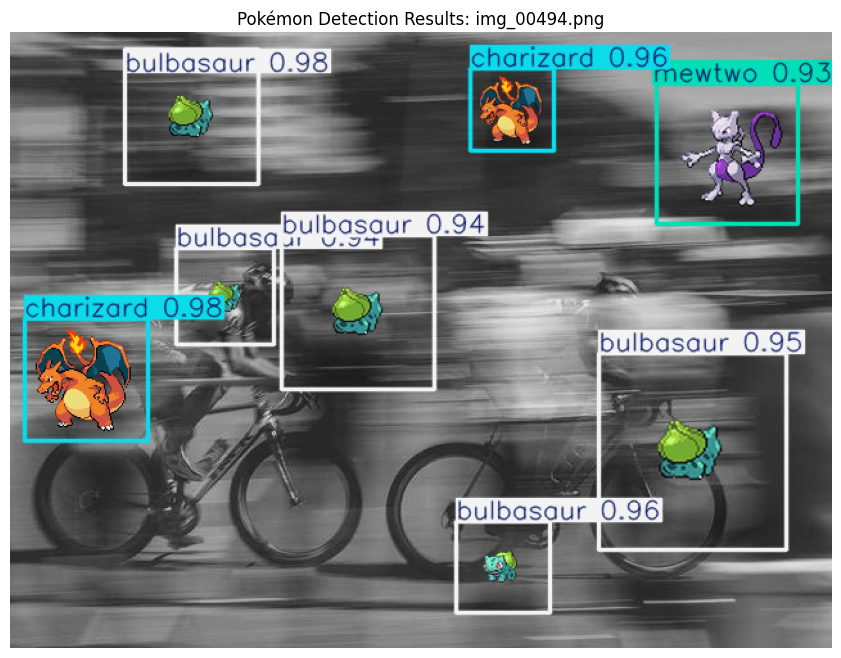

Detections:
  bulbasaur: 0.982 at [89.7, 13.7, 193.1, 118.6]
  charizard: 0.978 at [11.0, 223.8, 107.2, 318.3]
  charizard: 0.965 at [358.0, 28.8, 423.1, 92.8]
  bulbasaur: 0.959 at [347.1, 381.1, 420.6, 452.8]
  bulbasaur: 0.952 at [458.1, 250.7, 604.2, 403.6]
  bulbasaur: 0.942 at [211.6, 158.9, 330.7, 278.2]
  bulbasaur: 0.940 at [129.4, 168.9, 205.1, 243.4]
  mewtwo: 0.926 at [503.9, 40.0, 613.5, 149.0]


In [33]:
def test_custom_image():
    print("Upload an image to test the trained model:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nTesting on {filename}:")

        # Run inference
        results = trained_model(filename, conf=0.25)

        # Display results
        annotated_img = results[0].plot()
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_img)
        plt.title(f"Pokémon Detection Results: {filename}")
        plt.axis('off')
        plt.show()

        # Print detection details
        print(f"Detections:")
        if len(results[0].boxes) > 0:
            for j, box in enumerate(results[0].boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = class_names[class_id]
                bbox = box.xyxy[0].cpu().numpy()
                print(f"  {class_name}: {confidence:.3f} at [{bbox[0]:.1f}, {bbox[1]:.1f}, {bbox[2]:.1f}, {bbox[3]:.1f}]")
        else:
            print("  No Pokémon detected")

test_custom_image()

### Export Model

In [31]:
# Export the trained model to different formats
print("Exporting trained model...")

# Export to ONNX format (for deployment)
try:
    trained_model.export(format='onnx')
    print("Model exported to ONNX format successfully!")
except Exception as e:
    print(f"Failed to export to ONNX: {e}")

# Export to TorchScript format
try:
    trained_model.export(format='torchscript')
    print("Model exported to TorchScript format successfully!")
except Exception as e:
    print(f"Failed to export to TorchScript: {e}")

print(f"\nTraining completed! Best model saved at: {results_dir}/weights/best.pt")


Exporting trained model...
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.30GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/pokemon_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.67', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 6.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 19...
ONNX: slimming with onnxslim 0.1.68...
ONNX: export success ✅ 8.9s, saved as 'runs/detect/pokemon_detection/weights/best.onnx' (42.7 MB)

Export complete (10.5s)
Results saved to /content/runs/detect/pokemon_detection/weights
Predict:         yolo predict task=detect model=runs/de